## Summary
In this notebook, the Crüsemann data is analysed for the NPClassScore paper.

The newly developed implementation of NPClassScore is used in combination with Metcalf scoring to discover BGC-MS/MS spectrum links in the Crüsemann dataset. Validated links from the PoDP are used to validate the results.

Sections:
- Loading Crüsemann dataset
- Scoring using the new NPClassScore method
- Investigating NPClassScore cutoff
- Counting number of links
- Making plots showing the filtered links
- Investigate known links
- Check MNE coverage over MFs and compare to CANOPUS
- Scoring Spectra to GCF

## Loading Crüsemann dataset

In [205]:
import sys, csv, os
# if running from clone of the git repo
sys.path.append('../../prototype')

# import the main NPLinker class. normally this all that's required to work
# with NPLinker in a notebook environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nplinker.nplinker import NPLinker
from nplinker.nplinker import Spectrum
from collections import Counter, defaultdict

In [4]:
# load local crusemann data
npl = NPLinker({'dataset': {'root': '/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/'},
                'docker': {'run_canopus': True}})
npl.load_data()

15:05:15 [INFO] config.py:121, Loading from local data in directory /mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/
15:05:15 [WARNING] loader.py:50, WARNING: unable to find extra_nodes_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/quantification_table_reformatted/*.csv"
15:05:15 [WARNING] loader.py:50, WARNING: unable to find metadata_table_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/metadata_table/metadata_table*.txt"
15:05:15 [WARNING] loader.py:50, WARNING: unable to find quantification_table_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/quantification_table/quantification_table*.csv"
15:05:15 [INFO] loader.py:84, Trying to discover correct bigscape directory under /mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/bigscape
15:05:15 [INFO] loader.py:87, Found network files direc

True

In [6]:
# Basic functionality
# ===================
#
# Once you have an NPLinker object with all data loaded, there are a collection of simple
# methods and properties you can use to access objects and metadata. Some examples are 
# given below, see https://nplinker.readthedocs.io/en/latest/ for a complete API description.

# configuration/dataset metadata
# - a copy of the configuration as parsed from the .toml file (dict)
print(npl.config) 
# - the path to the directory where various nplinker data files are located (e.g. the 
#   default configuration file template) (str)
print(npl.data_dir)
# - a dataset ID, derived from the path for local datasets or the paired platform ID
#   for datasets loaded from that source (str)
print(npl.dataset_id)
# - the root directory for the current dataset (str)
print(npl.root_dir)

# objects
# - you can directly access lists of each of the 4 object types:
print('BGCs:', len(npl.bgcs))
print('GCFs:', len(npl.gcfs)) # contains GCF objects
print('Spectra:', len(npl.spectra)) # contains Spectrum objects
print('Molecular Families:', len(npl.molfams)) # contains MolecularFamily objects

{'loglevel': 'INFO', 'logfile': '', 'log_to_stdout': True, 'repro_file': '', 'dataset': {'root': '/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/', 'overrides': {}, 'platform_id': ''}, 'antismash': {'antismash_format': 'default', 'ignore_spaces': False}, 'docker': {'run_bigscape': True, 'extra_bigscape_parameters': '', 'run_canopus': True}, 'webapp': {'tables_metcalf_threshold': 2.0}, 'scoring': {'rosetta': {}}}
../../prototype/nplinker/data

/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/
BGCs: 5869
GCFs: 1581
Spectra: 13667
Molecular Families: 8346


## Scoring using the new NPClassScore method
Use the scoring methods in NPLinker to find links with:
- Metcalf scoring
- Metcalf + NPClassScore scoring

In [7]:
mc = npl.scoring_method('metcalf')

# Now mc is an instance of the class that implements Metcalf scoring. Once
# you have such an instance, you may change any of the parameters it exposes.
# In the case of Metcalf scoring, the following parameters are currently exposed:
# - cutoff (float): the scoring threshold. Links with scores less than this are excluded
# - standardised (bool): set to True to use standardised scores (default), False for regular
mc.cutoff = 2.5
mc.standardised = True

results = npl.get_links(npl.gcfs, mc, and_mode=True)

# get_links returns an instance of a class called LinkCollection. This provides a wrapper
# around the results of the scoring operation and has various useful properties/methods:
#
# - len(results) or .source_count will tell you how many of the input_objects were found to have links
print('Number of results: {}'.format(len(results)))
# - .sources is a list of those objects
objects_with_links = results.sources
# - .links is a dict with structure {input_object: {linked_object: ObjectLink}} 
objects_and_link_info = results.links
# - .get_all_targets() will return a flat list of *all* the linked objects (for all sources)
all_targets = results.get_all_targets() 
# - .methods is a list of the scoring methods passed to get_links
methods = results.methods

15:10:10 [INFO] methods.py:459, MetcalfScoring.setup (bgcs=5869, gcfs=1581, spectra=13667, molfams=8346, strains=154)
15:10:20 [INFO] methods.py:499, MetcalfScoring.setup completed
Number of results: 1581


In [219]:
# Initialise NPClassScore scoring the same way
# default method: 'mix' meaning use both CANOPUS and MolNetEnhancer with priority to CANOPUS
npcl = npl.scoring_method('npclassscore')
npcl.cutoff = 0.25

# Now only links are kept that pass the cutoff for both methods
results_both = npl.get_links(npl.gcfs, [mc, npcl], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_both)))
print(results_both.methods)

17:45:04 [INFO] methods.py:982, Running NPClassScore...
17:45:04 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
17:46:00 [INFO] methods.py:1003, Calculating NPClassScore for 1581 objects to 13667 targets (1784369 pairwise interactions that share at least 1 strain). This might take a while.
17:49:17 [INFO] methods.py:1052, NPClassScore completed in 252.9s
Number of results for Metcalf and NPClassScore scoring: 1574
{<nplinker.scoring.methods.MetcalfScoring object at 0x7f29f0f2f710>, <nplinker.scoring.methods.NPClassScoring object at 0x7f2901a58978>}


In [17]:
# Also create an object with both Metcalf and NPClassScore with a cutoff of 0 to investigate proper cutoff
npcl_0 = npl.scoring_method('npclassscore')
npcl_0.cutoff = 0

# Now only links are kept that pass the cutoff for both methods
results_0 = npl.get_links(npl.gcfs, [mc, npcl_0], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_0)))
print(results_0.methods)

15:29:54 [INFO] methods.py:982, Running NPClassScore...
15:29:55 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
15:31:40 [INFO] methods.py:1003, Calculating NPClassScore for 1581 objects to 13667 targets (1784369 pairwise interactions that share at least 1 strain). This might take a while.
15:37:37 [INFO] methods.py:1052, NPClassScore completed in 462.6s
Number of results for Metcalf and NPClassScore scoring: 1581
{<nplinker.scoring.methods.MetcalfScoring object at 0x7f29f0f2f710>, <nplinker.scoring.methods.NPClassScoring object at 0x7f29442be9e8>}


## Investigating NPClassScore cutoff
We choose 0.25 as a cutoff as around this value there is a marked drop in the number of links per GCF.

In [183]:
# gradient of class linking score cutoff

cs_cutoffs = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
d_all_num_links = []
d_all_num_filtered_links = {cut: [] for cut in cs_cutoffs}
d_all_no_scores = []

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum)])

    # init filtered links for each cutoff
    num_filtered_links = [0 for _ in range(len(cs_cutoffs))]
    for cs_cut in cs_cutoffs:
        num_filtered_links = 0
        if gcf in results_0.links:
            num_filtered_links = len([link_data for link_data in results_0.get_sorted_links(mc, gcf)
                                      if isinstance(link_data.target, Spectrum) and 
                                      float(npcl_0.format_data(link_data[npcl_0])) > cs_cut])
        d_all_num_filtered_links[cs_cut].append(num_filtered_links)
    d_all_num_links.append(num_links)
#     all_num_filtered_links.append(num_filtered_links)

In [186]:
print(f"NPClassScore_cutoff\tNumber_of_links\tChange")
print(f"0\t{np.mean(d_all_num_links):.2f}")
for cs_cut, filt_links in d_all_num_filtered_links.items():
    print(f"{cs_cut}\t{np.mean(filt_links):.2f}\t{(np.mean(filt_links)-np.mean(d_all_num_links))/np.mean(d_all_num_links):.2f}")

NPClassScore_cutoff	Number_of_links	Change
0	549.85
0.125	332.96	-0.39
0.25	177.00	-0.68
0.375	149.46	-0.73
0.5	115.89	-0.79
0.625	105.10	-0.81
0.75	64.19	-0.88
0.875	23.13	-0.96


## Counting number of links
For each GCF count the number of links with and without NPClassScore filtering using the chosen cutoff of 0.25.

In [179]:
# loop through all gcfs (objects) and count how many links exist (spectra)
all_num_links = []
all_num_filtered_links = []
all_no_scores = []

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum)])
    num_filtered_links = 0
    if gcf in results_both.links:
        num_filtered_links = len([link_data for link_data in results_both.get_sorted_links(mc, gcf)
                                  if isinstance(link_data.target, Spectrum)])
    all_num_links.append(num_links)
    all_num_filtered_links.append(num_filtered_links)

np.mean(all_num_links), np.mean(all_num_filtered_links)

(549.8481973434535, 177.0)

In [111]:
# change in average links per GCF
(np.mean(all_num_filtered_links)-np.mean(all_num_links))/np.mean(all_num_links)

-0.6780929702867792

## Making plots showing the filtered links

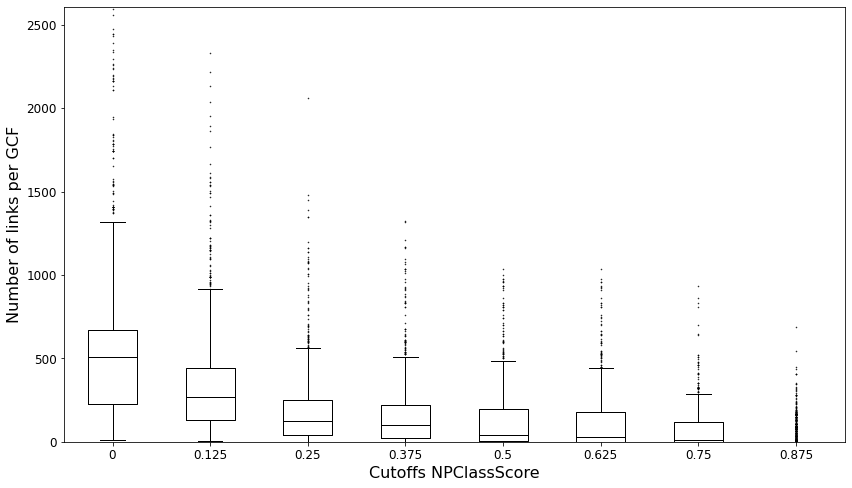

In [185]:
sorted_filt_items = sorted(d_all_num_filtered_links.items())
labels = ["0"] + [f"{cut}" for cut, vals in sorted_filt_items]
xs = [d_all_num_links] + [vals for keys, vals in sorted_filt_items]
lg_size = 14
custom_xlim = (-1, 2607)
links_title = "Number of links per GCF"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.boxplot(xs, labels=labels, flierprops={"markersize": 0.5}, medianprops={"color": "black"})
plt.setp(ax, ylim=custom_xlim, xlabel="Cutoffs NPClassScore", ylabel=links_title)
figout = "/home/louwe015/NPLinker/boxplot_cutoffs_npclass_mix_can-mne_figure.svg"
plt.savefig(figout)

Use MNE when there is no CANOPUS prediction


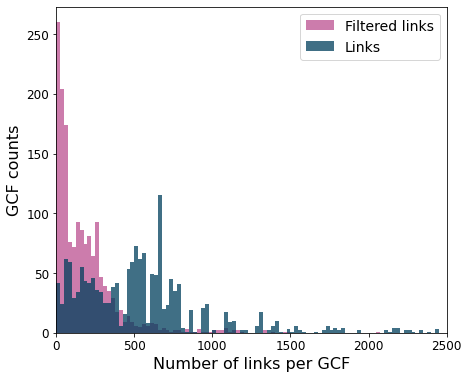

In [173]:
print("Use MNE when there is no CANOPUS prediction")
labels = ["Links", "Filtered links"]
colours = ["#003f5c", "#bc5090", "#ffa600"]
xs = [all_num_links, all_num_filtered_links]
lg_size = 14
custom_xlim = (-1, 2500)
bin_size = 25
n_bins = np.arange(0, 2500, bin_size)
links_title = "Number of links per GCF"
count_title = "GCF counts"
hist_type = "stepfilled"
alpha = 0.75

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
ax0.hist(xs[:2], bins=n_bins, density=False, histtype=hist_type, stacked=False, label=labels[:2],
         color=colours[:2], alpha=alpha)
ax0.legend(prop={'size': lg_size})
plt.setp(ax0, xlim=custom_xlim, xlabel=links_title, ylabel=count_title)
figout = "/home/louwe015/NPLinker/filtered_links_mix_can-mne_figure_new.svg"
plt.savefig(figout)

## Investigate known links

### Staurosporine

In [206]:
# Find the right GCF by seeing if this mibig occurs in the knownclusterblast results
key = 'bgc0000827'
result_bgcs = defaultdict(list)
interest_lines = []
for bgc in npl.bgcs:
    as_file = bgc.antismash_file
    with open(as_file) as inf:
        for x in range(1000):
            line = inf.readline().lower()
            if key in line:
                result_bgcs[bgc].append(line.strip())
print(len(result_bgcs))
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

26
{GCF(id=378, class=Others, gcf_id=5342, strains=13), GCF(id=587, class=Others, gcf_id=1275, strains=16), GCF(id=534, class=Others, gcf_id=511, strains=54), GCF(id=671, class=Others, gcf_id=2205, strains=1)} 4


In [207]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 534][0]
result_gcf, result_gcf.bgcs

(GCF(id=534, class=Others, gcf_id=511, strains=54),
 {BGC(id=1746, name=2515154186_c00001_B103DRA...cluster023, strain=Strain(Salinispora arenicola CNT798) [4 aliases], asid=c00007_B103DRA.., region=-1),
  BGC(id=1747, name=34967.assembled_unknown.cluster033, strain=Strain(Salinispora arenicola CNH643) [4 aliases], asid=unknown_6, region=-1),
  BGC(id=1748, name=34969.assembled_unknown.cluster037, strain=Strain(Salinispora arenicola CNQ884) [4 aliases], asid=unknown_15, region=-1),
  BGC(id=1749, name=35121.assembled_unknown.cluster028, strain=Strain(Salinispora arenicola CNY281) [4 aliases], asid=unknown_7, region=-1),
  BGC(id=1750, name=35123.assembled_unknown.cluster032, strain=Strain(Salinispora arenicola CNH718) [4 aliases], asid=unknown_4, region=-1),
  BGC(id=1751, name=35125.assembled_unknown.cluster031, strain=Strain(Salinispora arenicola CNY486) [4 aliases], asid=unknown_6, region=-1),
  BGC(id=1752, name=35128.assembled_unknown.cluster003, strain=Strain(Salinispora arenicol

In [220]:
cutoff = 0.25
result_links = results_both.get_sorted_links(mc, result_gcf)
result_links_ori = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
include_below_cutoff = False
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links:
    if count == 10:
        break
    if isinstance(link_data.target, Spectrum):
        i += 1
        print(link_data)
        cl_score = link_data[npcl_both]
        #float(npcl_0.format_data(link_data[npcl_0])) > cs_cut
        pref = 'x.'
        if cl_score:
            if cl_score[0][0] > cutoff:
                count += 1
                pref = f"{count}."
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{} = {}\tshared strains = {}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(link_data[mc]),
                len(link_data.shared_strains)))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            if link_data.target.gnps_annotations:
                print('Library match:', link_data.target.gnps_annotations.get("Compound_Name"))
            print('Precursor_mz:', link_data.target.precursor_mz)

Results for object: GCF(id=534, class=Others, gcf_id=511, strains=54), 21 total links, 1 methods used
Rank above cutoff (original rank)
ObjectLink(source=GCF(id=534, class=Others, gcf_id=511, strains=54), target=Spectrum(id=3632, spectrum_id=89513, strains=67), #methods=2)


NameError: name 'npcl_both' is not defined

In [295]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        cl_score = dev_score(npl, mne_res, result_gcf, link_data.target, 'mix')
        if cl_score:
            if cl_score[0][0] > cutoff:
                filtered_counts += 1
print(metcalf_counts, filtered_counts)

100 16


### Rosamicin

In [288]:
result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_AUGH01000019.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=3761, name=NZ_AUGH01000019.region001, strain=Strain(Salinispora pacifica CNS237) [23 aliases], asid=NZ_AUGH01000019, region=1)]
{GCF(id=944, class=PKSI, gcf_id=1354, strains=2)} 1


In [289]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 944][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=944, class=PKSI, gcf_id=1354, strains=2),
 StrainCollection(n=2) [Salinispora pacifica CNY646,Salinispora pacifica CNS237],
 {BGC(id=3760, name=35578.assembled_unknown.cluster037, strain=Strain(Salinispora pacifica CNY646) [4 aliases], asid=unknown_15, region=-1),
  BGC(id=3761, name=NZ_AUGH01000019.region001, strain=Strain(Salinispora pacifica CNS237) [23 aliases], asid=NZ_AUGH01000019, region=1)})

In [290]:
cutoff = 0.25
result_links = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
include_below_cutoff = False
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links:
    if count == 10:
        break
    if isinstance(link_data.target, Spectrum):
        i += 1
        cl_score = dev_score(npl, mne_res, result_gcf, link_data.target, 'mix') # npl.class_linking_score(result_gcf, link_data.target)
        pref = 'x.'
        if cl_score:
            if cl_score[0][0] > cutoff:
                count += 1
                pref = f"{count}."
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{} = {}\tshared strains = {}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(link_data[mc]),
                len(link_data.shared_strains)))
            if cl_score:
                print('CL score:', cl_score[0])
            if link_data.target.gnps_annotations:
                print('Library match:', link_data.target.gnps_annotations.get("Compound_Name"))
            print('Precursor_mz:', link_data.target.precursor_mz)

Results for object: GCF(id=944, class=PKSI, gcf_id=1354, strains=2), 503 total links, 1 methods used
Rank above cutoff (original rank)
1.(8)	Spectrum(id=2023, spectrum_id=57072, strains=1)	metcalf = 8.7178	shared strains = 1
CL score: (0.7590027700831025, 'mibig_classes', 'npc_pathway', 'Polyketide', 'Polyketides')
Library match: Rhodojaponin II
Precursor_mz: 435.272
2.(14)	Spectrum(id=5072, spectrum_id=111712, strains=1)	metcalf = 8.7178	shared strains = 1
CL score: (0.7590027700831025, 'mibig_classes', 'npc_pathway', 'Polyketide', 'Polyketides')
Library match: (2-chloro-4,5-difluorophenyl)-N-[2-(2-methylindol-3-yl)ethyl]carboxamide
Precursor_mz: 524.35797
3.(23)	Spectrum(id=6319, spectrum_id=130529, strains=1)	metcalf = 8.7178	shared strains = 1
CL score: (0.7590027700831025, 'mibig_classes', 'npc_pathway', 'Polyketide', 'Polyketides')
Library match: 21-hydroxyrosamicin 
Precursor_mz: 568.38397
4.(24)	Spectrum(id=7074, spectrum_id=141312, strains=1)	metcalf = 8.7178	shared strains = 

In [292]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        cl_score = dev_score(npl, mne_res, result_gcf, link_data.target, 'mix')
        if cl_score:
            if cl_score[0][0] > cutoff:
                filtered_counts += 1
print(metcalf_counts, filtered_counts)

275 38


In [72]:
other_options = ['NZ_KB904950.1.region001', 'NZ_AZWA01000049.region001']
result_bgcs = [bgc for bgc in npl.bgcs if bgc.name in other_options]
print(result_bgcs)
result_gcfs = Counter([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=4324, name=NZ_AZWA01000049.region001, strain=Strain(Salinispora pacifica CNT084) [33 aliases], asid=NZ_AZWA01000049, region=1), BGC(id=4325, name=NZ_KB904950.1.region001, strain=Strain(Salinispora pacifica CNT609) [29 aliases], asid=NZ_KB904950.1, region=1)]
Counter({GCF(id=1114, class=PKSI, gcf_id=5627, strains=2): 2}) 1


In [73]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 1114][0]
result_gcf, list(result_gcf.bgcs)[:2]

cutoff = 0.5
result_links = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
include_below_cutoff = False
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links:
    if count == 10:
        break
    if isinstance(link_data.target, Spectrum):
        i += 1
        cl_score = npl.class_linking_score(result_gcf, link_data.target)
        pref = 'x.'
        if cl_score:
            if cl_score[0][0] > cutoff:
                count += 1
                pref = f"{count}."
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{} = {}\tshared strains = {}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(link_data[mc]),
                len(link_data.shared_strains)))
            if cl_score:
                print('CL score:', cl_score[0])
            if link_data.target.gnps_annotations:
                print('Library match:', link_data.target.gnps_annotations.get("Compound_Name"))
            print('Precursor_mz:', link_data.target.precursor_mz)

Results for object: GCF(id=1114, class=PKSI, gcf_id=5627, strains=2), 434 total links, 1 methods used
Rank above cutoff (original rank)
1.(5)	Spectrum(id=7587, spectrum_id=146379, strains=1)	metcalf = 8.7178	shared strains = 1
CL score: (0.7590027700831025, 'mibig_classes', 'npc_pathway', 'Polyketide', 'Polyketides')
Library match: (2S,3R)-2-(((S)-7-acetamido-1,2,3-trimethoxy-9-oxo-5,6,7,9-tetrahydrobenzo[a]heptalen-10-yl)amino)-N-(4-(1,1-dioxido-1,2-thiazinan-2-yl)phenyl)-3-methylpentanamide
Precursor_mz: 616.36401
2.(46)	Spectrum(id=6318, spectrum_id=130522, strains=2)	metcalf = 6.1033	shared strains = 1
CL score: (0.7590027700831025, 'mibig_classes', 'npc_pathway', 'Polyketide', 'Polyketides')
Library match: NCGC00380724-01_C28H47NO8_(3R,5R,6S,7S,9R,11E,13S,14R)-14-Ethyl-13-hydroxy-3,5,7,9,13-pentamethyl-2,4,10-trioxooxacyclotetradec-11-en-6-yl 3,4,6-trideoxy-3-(dimethylamino)-D-xylo-hexopyranoside
Precursor_mz: 568.37799
3.(57)	Spectrum(id=10168, spectrum_id=186527, strains=2)	metc

### Desferrioxamine

In [74]:
from collections import Counter
key = 'bgc0000940'

result_bgcs = defaultdict(list)
interest_lines = []
for bgc in npl.bgcs:
    as_file = bgc.antismash_file
    with open(as_file) as inf:
        for x in range(1000):  # try to find knownclusterblast in the gbks
            line = inf.readline().lower()
            if key in line:
                result_bgcs[bgc].append(line.strip())
print(len(result_bgcs))
result_gcfs = Counter([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

37
Counter({GCF(id=528, class=Others, gcf_id=493, strains=50): 21, GCF(id=1453, class=Others, gcf_id=1087, strains=20): 20, GCF(id=908, class=Others, gcf_id=5613, strains=34): 9, GCF(id=839, class=Others, gcf_id=3562, strains=9): 4, GCF(id=575, class=Others, gcf_id=1051, strains=6): 2, GCF(id=618, class=Others, gcf_id=1514, strains=6): 1}) 6


In [75]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 528][0]
result_gcf, list(result_gcf.bgcs)[:2]

cutoff = 0.5
result_links = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
include_below_cutoff = False
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links:
    if count == 10:
        break
    if isinstance(link_data.target, Spectrum):
        i += 1
        cl_score = npl.class_linking_score(result_gcf, link_data.target)
        pref = 'x.'
        if cl_score:
            if cl_score[0][0] > cutoff:
                count += 1
                pref = f"{count}."
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{} = {}\tshared strains = {}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(link_data[mc]),
                len(link_data.shared_strains)))
            if cl_score:
                print('CL score:', cl_score[0])
            if link_data.target.gnps_annotations:
                print('Library match:', link_data.target.gnps_annotations.get("Compound_Name"))
            print('Precursor_mz:', link_data.target.precursor_mz)

Results for object: GCF(id=528, class=Others, gcf_id=493, strains=50), 191 total links, 1 methods used
Rank above cutoff (original rank)
1.(14)	Spectrum(id=4276, spectrum_id=100033, strains=13)	metcalf = 4.1828	shared strains = 11
CL score: (0.5555555555555556, 'as_classes', 'cf_superclass', 'siderophore', 'Organic acids and derivatives')
Library match: Flavokawain A
Precursor_mz: 499.20401
2.(18)	Spectrum(id=7723, spectrum_id=147515, strains=8)	metcalf = 4.1759	shared strains = 8
CL score: (0.6, 'as_classes', 'npc_pathway', 'siderophore', 'Amino acids and Peptides')
Library match: methyl 3-(6-((4-formylpiperazin-1-yl)methyl)-3-hydroxy-4-oxo-4H-pyran-2-yl)-3-(4-((1-methyl-1H-imidazol-2-yl)methoxy)phenyl)propanoate
Precursor_mz: 621.42499
3.(19)	Spectrum(id=10414, spectrum_id=189607, strains=15)	metcalf = 4.1247	shared strains = 12
CL score: (0.6, 'as_classes', 'npc_pathway', 'siderophore', 'Amino acids and Peptides')
Library match: (7S,9E,11S,12R,13S,14S,15S,16R,17S,18S,19E,21Z)-13-(ac

In [76]:
# second biggest gcf
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 1453][0]
result_gcf, list(result_gcf.bgcs)[:2]

cutoff = 0.5
result_links = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
include_below_cutoff = False
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links:
    if count == 10:
        break
    if isinstance(link_data.target, Spectrum):
        i += 1
        cl_score = npl.class_linking_score(result_gcf, link_data.target)
        pref = 'x.'
        if cl_score:
            if cl_score[0][0] > cutoff:
                count += 1
                pref = f"{count}."
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{} = {}\tshared strains = {}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(link_data[mc]),
                len(link_data.shared_strains)))
            if cl_score:
                print('CL score:', cl_score[0])
            if link_data.target.gnps_annotations:
                print('Library match:', link_data.target.gnps_annotations.get("Compound_Name"))
            print('Precursor_mz:', link_data.target.precursor_mz)

Results for object: GCF(id=1453, class=Others, gcf_id=1087, strains=20), 309 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=6540, spectrum_id=133084, strains=5)	metcalf = 5.8651	shared strains = 5
CL score: (0.5555555555555556, 'as_classes', 'cf_superclass', 'siderophore', 'Organic acids and derivatives')
Precursor_mz: 577.77698
2.(6)	Spectrum(id=4997, spectrum_id=110889, strains=23)	metcalf = 4.0308	shared strains = 9
CL score: (0.6, 'as_classes', 'npc_pathway', 'siderophore', 'Amino acids and Peptides')
Library match: NCGC00169091-02!4-methoxy-6-[2-(4-methoxyphenyl)ethyl]pyran-2-one [IIN-based on: CCMSLIB00000846463]
Precursor_mz: 521.28198
3.(7)	Spectrum(id=11543, spectrum_id=205717, strains=6)	metcalf = 3.9770	shared strains = 4
CL score: (0.5555555555555556, 'as_classes', 'cf_superclass', 'siderophore', 'Organic acids and derivatives')
Library match: Sodium Formate
Precursor_mz: 770.84601
4.(8)	Spectrum(id=3505, spectrum_id=87426, strains=4)	metcal

### Rifamycin

In [77]:
key = 'bgc0000137'
result_bgcs = defaultdict(list)
interest_lines = []
for bgc in npl.bgcs:
    as_file = bgc.antismash_file
    with open(as_file) as inf:
        for x in range(1000):  # try to find knownclusterblast in the gbks
            line = inf.readline().lower()
            if key in line:
                result_bgcs[bgc].append(line.strip())
print(len(result_bgcs))
result_gcfs = Counter([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

90
Counter({GCF(id=924, class=PKSI, gcf_id=382, strains=20): 20, GCF(id=1447, class=Saccharides, gcf_id=735, strains=20): 16, GCF(id=960, class=PKSI, gcf_id=2043, strains=18): 14, GCF(id=1488, class=Terpene, gcf_id=2299, strains=37): 8, GCF(id=511, class=Others, gcf_id=343, strains=5): 7, GCF(id=623, class=Others, gcf_id=1534, strains=7): 7, GCF(id=1106, class=PKSI, gcf_id=5101, strains=29): 7, GCF(id=1448, class=Saccharides, gcf_id=764, strains=9): 5, GCF(id=730, class=Others, gcf_id=2635, strains=3): 3, GCF(id=916, class=PKSI, gcf_id=127, strains=6): 3, GCF(id=1107, class=PKSI, gcf_id=5119, strains=45): 2, GCF(id=648, class=Others, gcf_id=1918, strains=17): 1, GCF(id=1576, class=Terpene, gcf_id=4995, strains=14): 1, GCF(id=391, class=NRPS, gcf_id=5596, strains=41): 1, GCF(id=1577, class=Terpene, gcf_id=5100, strains=9): 1, GCF(id=667, class=Others, gcf_id=2185, strains=1): 1, GCF(id=972, class=PKSI, gcf_id=2362, strains=1): 1, GCF(id=1552, class=Terpene, gcf_id=3583, strains=17): 1})

In [78]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 960][0]
result_gcf, list(result_gcf.bgcs)[:2]

cutoff = 0.25
result_links = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
include_below_cutoff = False
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links:
    if count == 10:
        break
    if isinstance(link_data.target, Spectrum):
        i += 1
        cl_score = npl.class_linking_score(result_gcf, link_data.target)
        pref = 'x.'
        if cl_score:
            if cl_score[0][0] > cutoff:
                count += 1
                pref = f"{count}."
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{} = {}\tshared strains = {}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(link_data[mc]),
                len(link_data.shared_strains)))
            if cl_score:
                print('CL score:', cl_score[0])
            if link_data.target.gnps_annotations:
                print('Library match:', link_data.target.gnps_annotations.get("Compound_Name"))
            print('Precursor_mz:', link_data.target.precursor_mz)

Results for object: GCF(id=960, class=PKSI, gcf_id=2043, strains=18), 293 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=8070, spectrum_id=151548, strains=4)	metcalf = 5.5522	shared strains = 4
CL score: (0.26903553299492383, 'mibig_classes', 'cf_superclass', 'Polyketide', 'Phenylpropanoids and polyketides')
Library match: NCGC00385035-01![8-[2-(3-methylbut-2-enoyloxy)propan-2-yl]-2-oxo-8,9-dihydrofuro[2,3-h]chromen-9-yl] (Z)-2-methylbut-2-enoate
Precursor_mz: 634.87201
2.(8)	Spectrum(id=2167, spectrum_id=62773, strains=2)	metcalf = 3.9001	shared strains = 2
CL score: (0.26903553299492383, 'mibig_classes', 'cf_superclass', 'Polyketide', 'Phenylpropanoids and polyketides')
Library match: Isocolumbin
Precursor_mz: 441.173
3.(23)	Spectrum(id=11537, spectrum_id=205706, strains=2)	metcalf = 3.9001	shared strains = 2
CL score: (0.26903553299492383, 'mibig_classes', 'cf_superclass', 'Polyketide', 'Phenylpropanoids and polyketides')
Library match: Sodium Format

### Actinomycin D

In [79]:
key = 'bgc0000296'
result_bgcs = defaultdict(list)
interest_lines = []
for bgc in npl.bgcs:
    as_file = bgc.antismash_file
    with open(as_file) as inf:
        for x in range(1000):  # try to find knownclusterblast in the gbks
            line = inf.readline().lower()
            if key in line:
                result_bgcs[bgc].append(line.strip())
print(len(result_bgcs))
result_gcfs = Counter([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

9
Counter({GCF(id=395, class=PKS-NRP_Hybrids, gcf_id=5752, strains=11): 6, GCF(id=935, class=PKS-NRP_Hybrids, gcf_id=733, strains=6): 6, GCF(id=29, class=PKS-NRP_Hybrids, gcf_id=1258, strains=9): 5, GCF(id=14, class=NRPS, gcf_id=597, strains=1): 1, GCF(id=492, class=Others, gcf_id=232, strains=1): 1, GCF(id=632, class=Others, gcf_id=1735, strains=4): 1}) 6


In [80]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 395][0]
print(result_gcf, list(result_gcf.bgcs))

cutoff = 0.25
result_links = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
include_below_cutoff = False
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links:
    if count == 10:
        break
    if isinstance(link_data.target, Spectrum):
        i += 1
        cl_score = npl.class_linking_score(result_gcf, link_data.target)
        pref = 'x.'
        if cl_score:
            if cl_score[0][0] > cutoff:
                count += 1
                pref = f"{count}."
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{} = {}\tshared strains = {}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(link_data[mc]),
                len(link_data.shared_strains)))
            if cl_score:
                print('CL score:', cl_score[0])
            if link_data.target.gnps_annotations:
                print('Library match:', link_data.target.gnps_annotations.get("Compound_Name"))
            print('Precursor_mz:', link_data.target.precursor_mz)

GCF(id=395, class=PKS-NRP_Hybrids, gcf_id=5752, strains=11) [BGC(id=105, name=35133.assembled_unknown.cluster061, strain=Strain(Salinispora arenicola CNY230) [4 aliases], asid=unknown_36, region=-1), BGC(id=106, name=35581.assembled_unknown.cluster039, strain=Strain(Salinispora pacifica CNY363) [4 aliases], asid=unknown_31, region=-1), BGC(id=107, name=36410.assembled_unknown.cluster052, strain=Strain(Salinispora arenicola CNS296) [4 aliases], asid=unknown_15, region=-1), BGC(id=108, name=38495.assembled_unknown.cluster053, strain=Strain(Salinispora arenicola CNS848) [4 aliases], asid=unknown_24, region=-1), BGC(id=109, name=NZ_AUKM01000028.region001, strain=Strain(Salinispora arenicola CNS299) [35 aliases], asid=NZ_AUKM01000028, region=1), BGC(id=110, name=NZ_AZWU01000037.region001, strain=Strain(Salinispora arenicola CNT005) [34 aliases], asid=NZ_AZWU01000037, region=1), BGC(id=111, name=NZ_KB896478.1.region001, strain=Strain(Salinispora arenicola CNY231) [27 aliases], asid=NZ_KB8964

In [81]:
# alternative, knownclusterblast has hit to JNLT01000010.1.region001
other_options = ['JNLT01000023.1.region001', 'JNLT01000010.1.region001']
result_bgcs = [bgc for bgc in npl.bgcs if bgc.name in other_options]
print(result_bgcs)
result_gcfs = Counter([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=537, name=JNLT01000010.1.region001, strain=Strain(Streptomyces sp. CNS654) [78 aliases], asid=JNLT01000010.1, region=1), BGC(id=544, name=JNLT01000023.1.region001, strain=Strain(Streptomyces sp. CNS654) [78 aliases], asid=JNLT01000023.1, region=1)]
Counter({GCF(id=212, class=NRPS, gcf_id=3444, strains=1): 1, GCF(id=218, class=NRPS, gcf_id=3462, strains=1): 1}) 2


In [82]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 218][0]
print(result_gcf, list(result_gcf.bgcs))

cutoff = 0.25
result_links = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
include_below_cutoff = False
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links:
    if count == 20:
        break
    if isinstance(link_data.target, Spectrum):
        i += 1
        cl_score = npl.class_linking_score(result_gcf, link_data.target)
        pref = 'x.'
        if cl_score:
            if cl_score[0][0] > cutoff:
                count += 1
                pref = f"{count}."
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{} = {}\tshared strains = {}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(link_data[mc]),
                len(link_data.shared_strains)))
            if cl_score:
                print('CL score:', cl_score[0])
            if link_data.target.gnps_annotations:
                print('Library match:', link_data.target.gnps_annotations.get("Compound_Name"))
            print('Precursor_mz:', link_data.target.precursor_mz)

GCF(id=218, class=NRPS, gcf_id=3462, strains=1) [BGC(id=544, name=JNLT01000023.1.region001, strain=Strain(Streptomyces sp. CNS654) [78 aliases], asid=JNLT01000023.1, region=1)]
Results for object: GCF(id=218, class=NRPS, gcf_id=3462, strains=1), 1021 total links, 1 methods used
Rank above cutoff (original rank)
1.(3)	Spectrum(id=374, spectrum_id=6563, strains=1)	metcalf = 12.3693	shared strains = 1
CL score: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Library match: (2E)-1-(3,4-dimethoxyphenyl)-3-(2-nitrophenyl)prop-2-en-1-one
Precursor_mz: 406.104
2.(4)	Spectrum(id=375, spectrum_id=6596, strains=1)	metcalf = 12.3693	shared strains = 1
CL score: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Library match: Dehydrodihydrorotenone
Precursor_mz: 406.168
3.(5)	Spectrum(id=469, spectrum_id=7835, strains=1)	metcalf = 12.3693	shared strains = 1
CL score: (0.7553763440860215, 'mibig_classes', 'cf

## Check MNE coverage over MFs and compare to CANOPUS

In [164]:
mne_component_dict = npl.chem_classes.molnetenhancer.molfam_classes
mne_cluster2component = npl.chem_classes.molnetenhancer.spectra2molfam
columns = npl.chem_classes.molnetenhancer.spectra_classes_names

In [160]:
column_counters = [Counter() for col in columns]

for values in mne_component_dict.values():
    for i, tup in enumerate(values):
        column_counters[i].update([tup[0]])

In [161]:
columns[1], column_counters[1], len(mne_component_dict)

('cf_superclass',
 Counter({'Benzenoids': 199,
          'Phenylpropanoids and polyketides': 1001,
          'Organoheterocyclic compounds': 484,
          'Alkaloids and derivatives': 110,
          'no matches': 3057,
          'Lipids and lipid-like molecules': 1512,
          'Organic acids and derivatives': 1605,
          'Organic oxygen compounds': 169,
          'Organic nitrogen compounds': 76,
          'Nucleosides, nucleotides, and analogues': 17,
          'Lignans, neolignans and related compounds': 56,
          'Organosulfur compounds': 1,
          'Hydrocarbon derivatives': 16,
          'Organic Polymers': 35,
          'Organohalogen compounds': 8}),
 8346)

cf_superclass 
 [(0.0, 3057), (0.1, 5), (0.2, 51), (0.3, 191), (0.4, 192), (0.5, 412), (0.6, 114), (0.7, 84), (0.8, 75), (0.9, 19), (1.0, 4146)] 
 8346


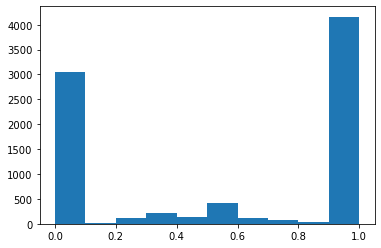

In [162]:
# now for scores rounded on 1 decimal
column_counters = [Counter() for col in columns]
column_vals = [[] for col in columns]
x = 1  # superclass

for values in mne_component_dict.values():
    for i, tup in enumerate(values):
        column_vals[i].append(tup[1])
        column_counters[i].update([round(tup[1],1)])
print(columns[x],'\n', sorted(column_counters[x].items()), '\n', len(mne_component_dict))
plt.hist(column_vals[x], bins=10)
plt.show()

In [165]:
# nodes with a superclass
node_superclass_counts = Counter()
for node, comp in mne_cluster2component.items():
    superclass = mne_component_dict[comp][1][0]
    node_superclass_counts.update([superclass])
columns[1], sorted(node_superclass_counts.most_common()), len(mne_cluster2component)

('cf_superclass',
 [('Alkaloids and derivatives', 173),
  ('Benzenoids', 281),
  ('Hydrocarbon derivatives', 17),
  ('Lignans, neolignans and related compounds', 61),
  ('Lipids and lipid-like molecules', 4597),
  ('Nucleosides, nucleotides, and analogues', 18),
  ('Organic Polymers', 105),
  ('Organic acids and derivatives', 2437),
  ('Organic nitrogen compounds', 79),
  ('Organic oxygen compounds', 231),
  ('Organohalogen compounds', 16),
  ('Organoheterocyclic compounds', 1013),
  ('Organosulfur compounds', 1),
  ('Phenylpropanoids and polyketides', 1528),
  ('no matches', 3110)],
 13667)

In [166]:
for t1,t2 in sorted(node_superclass_counts.most_common()):
    print(f'{t1}\t{t2}')

Alkaloids and derivatives	173
Benzenoids	281
Hydrocarbon derivatives	17
Lignans, neolignans and related compounds	61
Lipids and lipid-like molecules	4597
Nucleosides, nucleotides, and analogues	18
Organic Polymers	105
Organic acids and derivatives	2437
Organic nitrogen compounds	79
Organic oxygen compounds	231
Organohalogen compounds	16
Organoheterocyclic compounds	1013
Organosulfur compounds	1
Phenylpropanoids and polyketides	1528
no matches	3110


In [167]:
sum(node_superclass_counts.values()) - 3110  # minus 'no matches'

10557

In [168]:
# nodes with a superclass <850 Da to compare to canopus
node_superclass_counts_cut = Counter()
cut = 850
for node, comp in mne_cluster2component.items():
    spec = [spec for spec in npl.spectra if spec.spectrum_id == int(node)][0]
    if spec.parent_mz < cut:
        superclass = mne_component_dict[comp][1][0]
        node_superclass_counts_cut.update([superclass])
columns[1], node_superclass_counts_cut, sum(node_superclass_counts_cut.values())

('cf_superclass',
 Counter({'Benzenoids': 263,
          'Phenylpropanoids and polyketides': 1373,
          'Organoheterocyclic compounds': 981,
          'Alkaloids and derivatives': 150,
          'no matches': 2633,
          'Lipids and lipid-like molecules': 3603,
          'Organic acids and derivatives': 1865,
          'Organic oxygen compounds': 209,
          'Organic nitrogen compounds': 78,
          'Nucleosides, nucleotides, and analogues': 18,
          'Lignans, neolignans and related compounds': 60,
          'Organosulfur compounds': 1,
          'Hydrocarbon derivatives': 14,
          'Organohalogen compounds': 16,
          'Organic Polymers': 10}),
 11274)

In [327]:
for t1,t2 in sorted(node_superclass_counts_cut.most_common()):
    print(f'{t1}\t{t2}')

Alkaloids and derivatives	150
Benzenoids	263
Hydrocarbon derivatives	14
Lignans, neolignans and related compounds	60
Lipids and lipid-like molecules	3603
Nucleosides, nucleotides, and analogues	18
Organic Polymers	10
Organic acids and derivatives	1865
Organic nitrogen compounds	78
Organic oxygen compounds	209
Organohalogen compounds	16
Organoheterocyclic compounds	981
Organosulfur compounds	1
Phenylpropanoids and polyketides	1373
no matches	2633


In [328]:
# nodes with a superclass that have canopus prediction
node_superclass_counts_also_canopus = Counter()
for node, comp in mne_cluster2component.items():
    spec = [spec for spec in npl.spectra if spec.spectrum_id == int(node)][0]
    if node in npl.canopus.spectra_classes:
        superclass = mne_component_dict[comp][1][0]
        node_superclass_counts_also_canopus.update([superclass])
columns[1], node_superclass_counts_also_canopus, sum(node_superclass_counts_also_canopus.values())

('cf_superclass',
 Counter({'Benzenoids': 203,
          'Phenylpropanoids and polyketides': 951,
          'Organoheterocyclic compounds': 773,
          'Alkaloids and derivatives': 119,
          'no matches': 1940,
          'Lipids and lipid-like molecules': 2686,
          'Organic acids and derivatives': 1553,
          'Organic oxygen compounds': 165,
          'Organic nitrogen compounds': 72,
          'Nucleosides, nucleotides, and analogues': 16,
          'Lignans, neolignans and related compounds': 33,
          'Organosulfur compounds': 1,
          'Hydrocarbon derivatives': 8,
          'Organohalogen compounds': 16,
          'Organic Polymers': 10}),
 8546)

In [329]:
for t1,t2 in sorted(node_superclass_counts_also_canopus.most_common()):
    print(f'{t1}\t{t2}')

Alkaloids and derivatives	119
Benzenoids	203
Hydrocarbon derivatives	8
Lignans, neolignans and related compounds	33
Lipids and lipid-like molecules	2686
Nucleosides, nucleotides, and analogues	16
Organic Polymers	10
Organic acids and derivatives	1553
Organic nitrogen compounds	72
Organic oxygen compounds	165
Organohalogen compounds	16
Organoheterocyclic compounds	773
Organosulfur compounds	1
Phenylpropanoids and polyketides	951
no matches	1940


In [324]:
# compare to CANOPUS
node_canopus_superclass_count = Counter()
for spectrum in npl.spectra:
    classes = npl.canopus.spectra_classes.get(str(spectrum.spectrum_id))
    if classes:
        node_canopus_superclass_count.update([classes[1][0][0]])
npl.canopus.spectra_classes_names[1], sorted(node_canopus_superclass_count.most_common()), sum(node_canopus_superclass_count.values())

('cf_superclass',
 [('Alkaloids and derivatives', 9),
  ('Benzenoids', 522),
  ('Hydrocarbon derivatives', 13),
  ('Hydrocarbons', 1),
  ('Lignans, neolignans and related compounds', 3),
  ('Lipids and lipid-like molecules', 1647),
  ('Nucleosides, nucleotides, and analogues', 136),
  ('Organic 1,3-dipolar compounds', 30),
  ('Organic Polymers', 2),
  ('Organic acids and derivatives', 4057),
  ('Organic nitrogen compounds', 280),
  ('Organic oxygen compounds', 882),
  ('Organoheterocyclic compounds', 731),
  ('Organophosphorus compounds', 2),
  ('Organosulfur compounds', 29),
  ('Phenylpropanoids and polyketides', 202)],
 8546)

In [325]:
for t1,t2 in sorted(node_canopus_superclass_count.most_common()):
    print(f"{t1}\t{t2}")

Alkaloids and derivatives	9
Benzenoids	522
Hydrocarbon derivatives	13
Hydrocarbons	1
Lignans, neolignans and related compounds	3
Lipids and lipid-like molecules	1647
Nucleosides, nucleotides, and analogues	136
Organic 1,3-dipolar compounds	30
Organic Polymers	2
Organic acids and derivatives	4057
Organic nitrogen compounds	280
Organic oxygen compounds	882
Organoheterocyclic compounds	731
Organophosphorus compounds	2
Organosulfur compounds	29
Phenylpropanoids and polyketides	202


In [334]:
# canopus predictions that also have MNE predictions
canopus_also_mne_superclass = Counter()
for node, comp in mne_cluster2component.items():
    spec = [spec for spec in npl.spectra if spec.spectrum_id == int(node)][0]
    if mne_component_dict[comp][1][0] and not mne_component_dict[comp][1][0] == 'no matches':
        classes = npl.canopus.spectra_classes.get(node)
        if classes:
            superclass = classes[1][0][0]
            canopus_also_mne_superclass.update([superclass])
columns[1], canopus_also_mne_superclass, sum(canopus_also_mne_superclass.values())

('cf_superclass',
 Counter({'Benzenoids': 338,
          'Lipids and lipid-like molecules': 1301,
          'Organic nitrogen compounds': 243,
          'Nucleosides, nucleotides, and analogues': 81,
          'Hydrocarbon derivatives': 13,
          'Organic oxygen compounds': 700,
          'Organic acids and derivatives': 3229,
          'Organoheterocyclic compounds': 534,
          'Phenylpropanoids and polyketides': 113,
          'Organosulfur compounds': 24,
          'Alkaloids and derivatives': 7,
          'Organic 1,3-dipolar compounds': 16,
          'Lignans, neolignans and related compounds': 3,
          'Organophosphorus compounds': 2,
          'Hydrocarbons': 1,
          'Organic Polymers': 1}),
 6606)

In [335]:
for t1,t2 in sorted(canopus_also_mne_superclass.most_common()):
    print(f"{t1}\t{t2}")

Alkaloids and derivatives	7
Benzenoids	338
Hydrocarbon derivatives	13
Hydrocarbons	1
Lignans, neolignans and related compounds	3
Lipids and lipid-like molecules	1301
Nucleosides, nucleotides, and analogues	81
Organic 1,3-dipolar compounds	16
Organic Polymers	1
Organic acids and derivatives	3229
Organic nitrogen compounds	243
Organic oxygen compounds	700
Organoheterocyclic compounds	534
Organophosphorus compounds	2
Organosulfur compounds	24
Phenylpropanoids and polyketides	113


In [318]:
len(npl.canopus.spectra_classes)

8546

## Scoring Spectra to GCF
Do the same analysis as above but scoring from the spectrum side to the GCFs.

To get a similar number of links removed as for the GCFs, a cutoff of 0.4 seems reasonable

In [176]:
results_spec = npl.get_links(npl.spectra, mc, and_mode=True)

print('Number of results: {}'.format(len(results_spec)))

Number of results: 13374


In [180]:
results_0_spec = npl.get_links(npl.spectra, [mc, npcl_0], and_mode=True)

print('Number of results: {}'.format(len(results_both_spec)))

16:34:01 [INFO] methods.py:982, Running NPClassScore...
16:34:01 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
16:35:17 [INFO] methods.py:1003, Calculating NPClassScore for 13667 objects to 1581 targets (1784369 pairwise interactions that share at least 1 strain). This might take a while.
16:39:08 [INFO] methods.py:1052, NPClassScore completed in 307.7s
Number of results: 12178


In [193]:
# gradient of class linking score cutoff for spectrum -> GCF

cs_cutoffs = np.arange(0.1, 1, 0.1)
d_all_num_links_spec = []
d_all_num_filtered_links_spec = {cut: [] for cut in cs_cutoffs}
d_all_no_scores_spec = []

for spec in npl.spectra:
    num_links = 0
    if spec in results_spec.links:
        num_links = len([link_data for link_data in results_spec.get_sorted_links(mc, spec)])

    for cs_cut in cs_cutoffs:
        num_filtered_links = 0
        if spec in results_0_spec.links:
            num_filtered_links = len([link_data for link_data in results_0_spec.get_sorted_links(mc, spec) 
                                      if float(npcl_0.format_data(link_data[npcl_0])) > cs_cut])
        d_all_num_filtered_links_spec[cs_cut].append(num_filtered_links)
    d_all_num_links_spec.append(num_links)
#     all_num_filtered_links.append(num_filtered_links)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [195]:
print(f"NPClassScore_cutoff\tNumber_of_links\tChange")
print(f"0\t{np.mean(d_all_num_links_spec):.2f}")
for cs_cut, filt_links in d_all_num_filtered_links_spec.items():
    print(f"{cs_cut:.1f}\t{np.mean(filt_links):.2f}\t{(np.mean(filt_links)-np.mean(d_all_num_links_spec))/np.mean(d_all_num_links_spec):.2f}")

NPClassScore_cutoff	Number_of_links	Change
0	64.69
0.1	46.34	-0.28
0.2	37.72	-0.42
0.3	30.31	-0.53
0.4	23.24	-0.64
0.5	12.79	-0.80
0.6	9.68	-0.85
0.7	6.52	-0.90
0.8	4.61	-0.93
0.9	3.94	-0.94


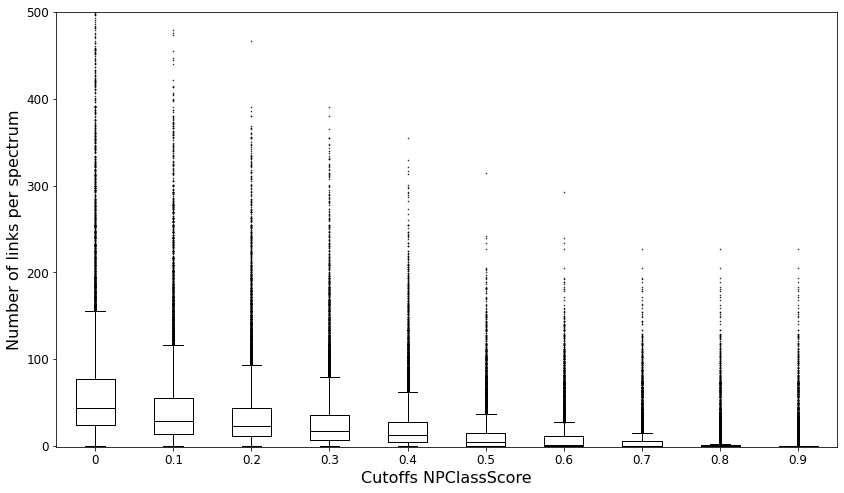

In [197]:
sorted_filt_items_spec = sorted(d_all_num_filtered_links_spec.items())
labels_spec = ["0"] + [f"{cut:.1f}" for cut, vals in sorted_filt_items_spec]
xs_spec = [d_all_num_links_spec] + [vals for keys, vals in sorted_filt_items_spec]
lg_size = 14
custom_xlim = (-1, 500)
links_title_spec = "Number of links per spectrum"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.boxplot(xs_spec, labels=labels_spec, flierprops={"markersize": 0.5}, medianprops={"color": "black"})
plt.setp(ax, ylim=custom_xlim, xlabel="Cutoffs NPClassScore", ylabel=links_title_spec)
figout = "/home/louwe015/NPLinker/boxplot_cutoffs_npclass_spectra_mix_can-mne_figure.svg"
plt.savefig(figout)

In [216]:
npcl_spec = npl.scoring_method('npclassscore')
npcl_spec.cutoff = 0.4
results_both_spec = npl.get_links(npl.spectra, [mc, npcl_spec], and_mode=True)

print('Number of results: {}'.format(len(results_both_spec)))

17:39:04 [INFO] methods.py:982, Running NPClassScore...
17:39:05 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
17:40:09 [INFO] methods.py:1003, Calculating NPClassScore for 13667 objects to 1581 targets (1784369 pairwise interactions that share at least 1 strain). This might take a while.
17:43:17 [INFO] methods.py:1052, NPClassScore completed in 252.0s
Number of results: 11735


For each GCF count the number of links with and without NPClassScore filtering using the chosen cutoff of 0.4.

In [217]:
# loop through all gcfs (objects) and count how many links exist (spectra)
all_num_links_spec = []
all_num_filtered_links_spec = []
all_no_scores_spec = []

for spec in npl.spectra:
    num_links = 0
    if spec in results_spec.links:
        num_links = len([link_data for link_data in results_spec.get_sorted_links(mc, spec)])

    num_filtered_links = 0
    if spec in results_both_spec.links:
        num_filtered_links = len([link_data for link_data in results_both_spec.get_sorted_links(mc, spec)])
    all_num_links_spec.append(num_links)
    all_num_filtered_links_spec.append(num_filtered_links)

np.mean(all_num_links_spec), np.mean(all_num_filtered_links_spec)

(64.69371478744421, 23.242920904368187)

Use MNE when there is no CANOPUS prediction


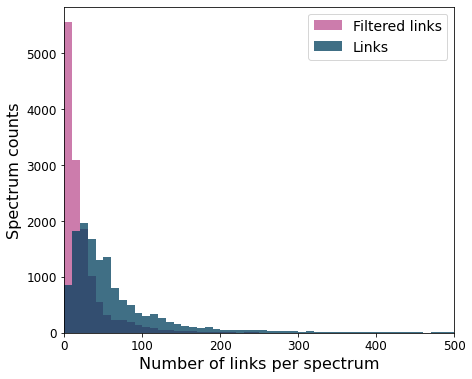

In [218]:
print("Use MNE when there is no CANOPUS prediction")
labels = ["Links", "Filtered links"]
colours = ["#003f5c", "#bc5090", "#ffa600"]
xs = [all_num_links_spec, all_num_filtered_links_spec]
lg_size = 14
custom_xlim = (-1, 500)
bin_size = 10
n_bins = np.arange(0, 2500, bin_size)
links_title = "Number of links per spectrum"
count_title = "Spectrum counts"
hist_type = "stepfilled"
alpha = 0.75

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
ax0.hist(xs[:2], bins=n_bins, density=False, histtype=hist_type, stacked=False, label=labels[:2],
         color=colours[:2], alpha=alpha)
ax0.legend(prop={'size': lg_size})
plt.setp(ax0, xlim=custom_xlim, xlabel=links_title, ylabel=count_title)
figout = "/home/louwe015/NPLinker/filtered_links_spectra_mix_can-mne_figure_new.svg"
plt.savefig(figout)